In [156]:
import math
import os
from pathlib import Path

import numpy as np
import librosa as lb
import soundfile as sf
import pyaudio

import torch
import torch.nn as nn
import torch.nn.functional as F

import 

import matplotlib.pyplot as plt
%matplotlib inline

import pickle as pkl

from models.VAE_1 import VAE_1
from utils.prepare_data import pad_or_trim

from utils.config import load_config

SyntaxError: invalid syntax (226278823.py, line 14)

In [ ]:
def play_wave(wave, sr):
    # initialize PyAudio
    p = pyaudio.PyAudio()

    # open a stream
    stream = p.open(format=pyaudio.paFloat32,
                    channels=1,
                    rate=sr,
                    output=True)

    # play audio
    stream.write(wave.tobytes())

    # stop stream and terminate PyAudio
    stream.stop_stream()
    stream.close()
    p.terminate()

In [ ]:
def load_wave(path):
    sample, sr = lb.load(path)
    return sample, sr

def load_random_wave(sample_type, path_to_samples = r"C:\Users\llama\Desktop\cuni\bakalarka\Bachelor_thesis-Electronic_music\data\drums-one_shots"):
    # load random wave
    path = os.path.join(path_to_samples, sample_type, f'{sample_type}_samples')

    sample_name = np.random.choice(os.listdir(path))
    sample, sr = load_wave(os.path.join(path, sample_name))
    return sample, sr

def load_all_waves(sample_types: list, path_to_samples = r"C:\Users\llama\Desktop\cuni\bakalarka\Bachelor_thesis-Electronic_music\data\drums-one_shots"):
    waves = []
    for sample_type in sample_types:
        path = os.path.join(path_to_samples, sample_type, f'{sample_type}_samples')
        for sample_name in os.listdir(path):
            sample, sr = load_wave(os.path.join(path, sample_name))
            waves.append((sample, sr))
    return waves

def convert_to_mfcc(wave, sr):
    mfcc = lb.feature.mfcc(y=wave, sr=sr, **MFCC_KWARGS)
    return mfcc

def convert_to_wave(mfcc, sr):
    return lb.feature.inverse.mfcc_to_audio(mfcc=mfcc, sr=sr, **INVERSE_MFCC_KWARGS)

In [232]:
def sample_from_latent_space(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

def fuse_sampled_samples(samples, weights = None):
    if weights is None:
        weights = np.ones(len(samples)) / len(samples)
    return np.average(samples, axis=0, weights=weights).astype(np.float32)

In [174]:
import sys
sys.path.append(r'C:\Users\llama\Desktop\cuni\bakalarka\Bachelor_thesis-Electronic_music')


model_dir_path = Path(r'C:\Users\llama\Desktop\cuni\bakalarka\Bachelor_thesis-Electronic_music\trained_models\model_all_latent-dims=16_noise=multiplicative')
model_name = os.path.basename(model_dir_path)
config = load_config(model_dir_path / f'{model_name}_config.pkl')

model = VAE_1(config.latent_dim)
model.load_state_dict(torch.load(model_dir_path / f'model_{model_name}.pkl', map_location=torch.device('cpu')))

<All keys matched successfully>

In [175]:
MFCC_KWARGS = config.mfcc_kwargs

INVERSE_MFCC_KWARGS = {
    'n_mels': MFCC_KWARGS['n_mels'],
    'dct_type': MFCC_KWARGS['dct_type'],
    'norm': MFCC_KWARGS['norm'],
    'lifter': MFCC_KWARGS['lifter'],
    'n_fft': MFCC_KWARGS['n_fft'],
    'hop_length': MFCC_KWARGS['hop_length'],
    'win_length': MFCC_KWARGS['win_length'],
    'window':  MFCC_KWARGS['window'],
    'center': MFCC_KWARGS['center'],
    'pad_mode': MFCC_KWARGS['pad_mode'],
    'power': MFCC_KWARGS['power'],

    ####
    # 'sr': 22050,
    ####

    'ref': 1.0,
    'n_iter': 32,
    'length': None,
    'dtype': np.float32
}


In [227]:
wave, sr = load_random_wave('clap')
x = pad_or_trim(convert_to_mfcc(wave, sr), length=100)


reconstructed_x, mu, logvar = model(torch.tensor(x).view(1, 1, *x.shape))

reconstructed_wave = convert_to_wave(reconstructed_x.detach().numpy().reshape(-1, 100), sr)

sampled_x = model.decoder.forward(sample_from_latent_space(mu, logvar))

play_wave(wave, sr)
play_wave(reconstructed_wave, sr)
play_wave(convert_to_wave(sampled_x.detach().numpy().reshape(-1, 100), sr), sr)

c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\feature\inverse.py:99: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(


In [246]:
wave_1, sr_1 = load_random_wave('hat')
wave_2, sr_2 = load_random_wave('kick')

x_1 = pad_or_trim(convert_to_mfcc(wave_1, sr_1), length=100)
x_2 = pad_or_trim(convert_to_mfcc(wave_2, sr_2), length=100)

reconstructed_x_1, mu_1, logvar_1 = model(torch.tensor(x_1).view(1, 1, *x_1.shape))
reconstructed_x_2, mu_2, logvar_2 = model(torch.tensor(x_2).view(1, 1, *x_2.shape))

sampled_x_1 = model.decoder.forward(sample_from_latent_space(mu_1, logvar_1))
sampled_x_2 = model.decoder.forward(sample_from_latent_space(mu_2, logvar_2))

fusion = fuse_sampled_samples([sampled_x_1.detach().numpy().reshape(-1, 100), sampled_x_2.detach().numpy().reshape(-1, 100)], weights=[0.5, 0.5])

fusion_wave = convert_to_wave(model.encoder.forward(torch.tensor(fusion).view(1, 1, *fusion.shape))[0].detach().numpy(), sr_1)

play_wave(wave_1, sr)
play_wave(wave_2, sr)
play_wave(convert_to_wave(fusion, sr), sr)

In [248]:
sample_groups = config.sample_group.split(',') if config.sample_group != 'all' else ['kick', 'clap', 'hat', 'snare', 'tom', 'cymbal', 'crash', 'ride']

mfccs = [pad_or_trim(convert_to_mfcc(wave, sr), length=100) for wave, sr in load_all_waves(sample_groups)]

means_logvars = [model.encoder(torch.tensor(x).view(1, 1, *x.shape)) for x in mfccs]

c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=510
  warnings.warn(
c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=415
  warnings.warn(
c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=277
  warnings.warn(
c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=306
  warnings.w

(array([  1.,   0.,   3.,   1.,   5.,   9.,  10.,  18.,  35.,  44.,  64.,
         65.,  93., 101., 133., 161., 207., 276., 315., 317., 362., 390.,
        457., 455., 494., 486., 484., 472., 500., 455., 404., 334., 368.,
        284., 254., 249., 240., 223., 206., 169., 179., 177., 178., 175.,
        171., 161., 159., 160., 130., 165., 137., 177., 152., 147., 131.,
        140., 139., 106.,  90.,  83.,  79.,  72.,  50.,  54.,  46.,  59.,
         41.,  39.,  49.,  37.,  27.,  35.,  36.,  30.,  31.,  20.,  17.,
         23.,  16.,  10.,  13.,  11.,  10.,   9.,   8.,   9.,   4.,   2.,
          3.,   3.,   2.,   3.,   5.,   1.,   2.,   0.,   0.,   3.,   0.,
          1.]),
 array([22.52238526, 23.02555249, 23.52871972, 24.03188696, 24.53505419,
        25.03822142, 25.54138865, 26.04455588, 26.54772311, 27.05089035,
        27.55405758, 28.05722481, 28.56039204, 29.06355927, 29.56672651,
        30.06989374, 30.57306097, 31.0762282 , 31.57939543, 32.08256267,
        32.5857299 , 33.08

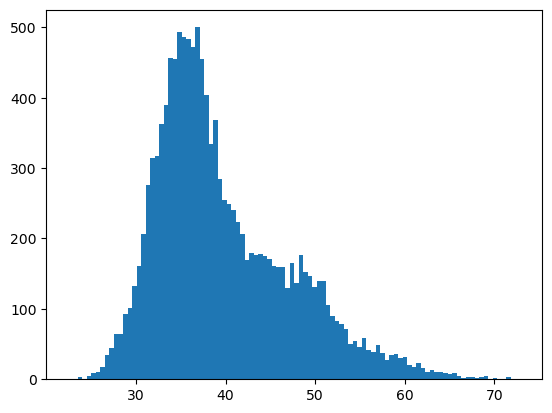

In [249]:
center = np.zeros(config.latent_dim)

euler_dists = [np.linalg.norm(mean.detach().numpy() - center) for mean, _ in means_logvars]

plt.hist(euler_dists, bins=100)